In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import h5py
from datetime import datetime, timedelta
# Veriyi yükleme ve önişleme
def load_data():
    # Veriyi CSV formatından yükle
    df = pd.read_csv('XRP_normalized.csv', parse_dates=['Date'])

    # Eksik değerleri kontrol et ve temizle
    print("Eksik değer sayısı:", df.isnull().sum().sum())
    df = df.dropna(subset=['Price'])

    # Tarihe göre sırala
    df = df.sort_values('Date')

    # Sadece 'Price' sütununu kullan
    prices = df[['Date', 'Price']].set_index('Date')
    return prices

# Veri setini yükle
data = load_data()

# Veriyi ölçeklendirme
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Zaman serisi verilerini LSTM için hazırlama
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Parametreler
SEQ_LENGTH = 60  # 3 aylık geçmiş veri
TEST_SIZE = 0.3  #%30 test verisi

# Veriyi dizilere dönüştür
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Eğitim-test bölümlemesi
split_idx = int(len(X) * (1 - TEST_SIZE))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# LSTM modelini oluşturma
model = Sequential([
    LSTM(144, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    Dropout(0.24),
    LSTM(72, return_sequences=True),
    Dropout(0.24),
    LSTM(36,return_sequences=False)
    Dropout(0.24)
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Erken durdurma
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Modeli eğitme
history = model.fit(
    X_train, y_train,
    epochs=32,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# Save the model
#model.save('XRP_lstm_model2.h5')

# Eğitim geçmişini kaydetme
#joblib.dump(history.history, 'XRP_history2.pkl')

# Tahmin yapma
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Ölçeklendirmeyi tersine çevirme
train_predict = scaler.inverse_transform(train_predict)
y_train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform(y_test)

# Metrikleri hesaplama fonksiyonu
def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predicted)

    # Adjusted R2 hesaplama
    n = len(actual)
    p = 1  # Bağımsız değişken sayısı
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'Adjusted R2': adj_r2
    }

# Eğitim ve test metrikleri
train_metrics = calculate_metrics(y_train_actual, train_predict)
test_metrics = calculate_metrics(y_test_actual, test_predict)

print("\nEğitim Seti Metrikleri:")
for metric, value in train_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nTest Seti Metrikleri:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")


Eksik değer sayısı: 0
Epoch 1/32


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0137 - val_loss: 0.0052
Epoch 2/32
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0030 - val_loss: 0.0039
Epoch 3/32
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0029 - val_loss: 0.0043
Epoch 4/32
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0023 - val_loss: 0.0049
Epoch 5/32
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0015 - val_loss: 0.0038
Epoch 6/32
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0015 - val_loss: 0.0051
Epoch 7/32
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0017 - val_loss: 0.0051
Epoch 8/32
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0014 - val_loss: 0.0036
Epoch 9/32
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0012 - val_loss: 0.0040
Epoch 10/32
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0011 - val_loss: 0.0037
Epoch 11/32
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0012 - val_loss: 0.0038
Epoch 12/32
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0013 - val_l

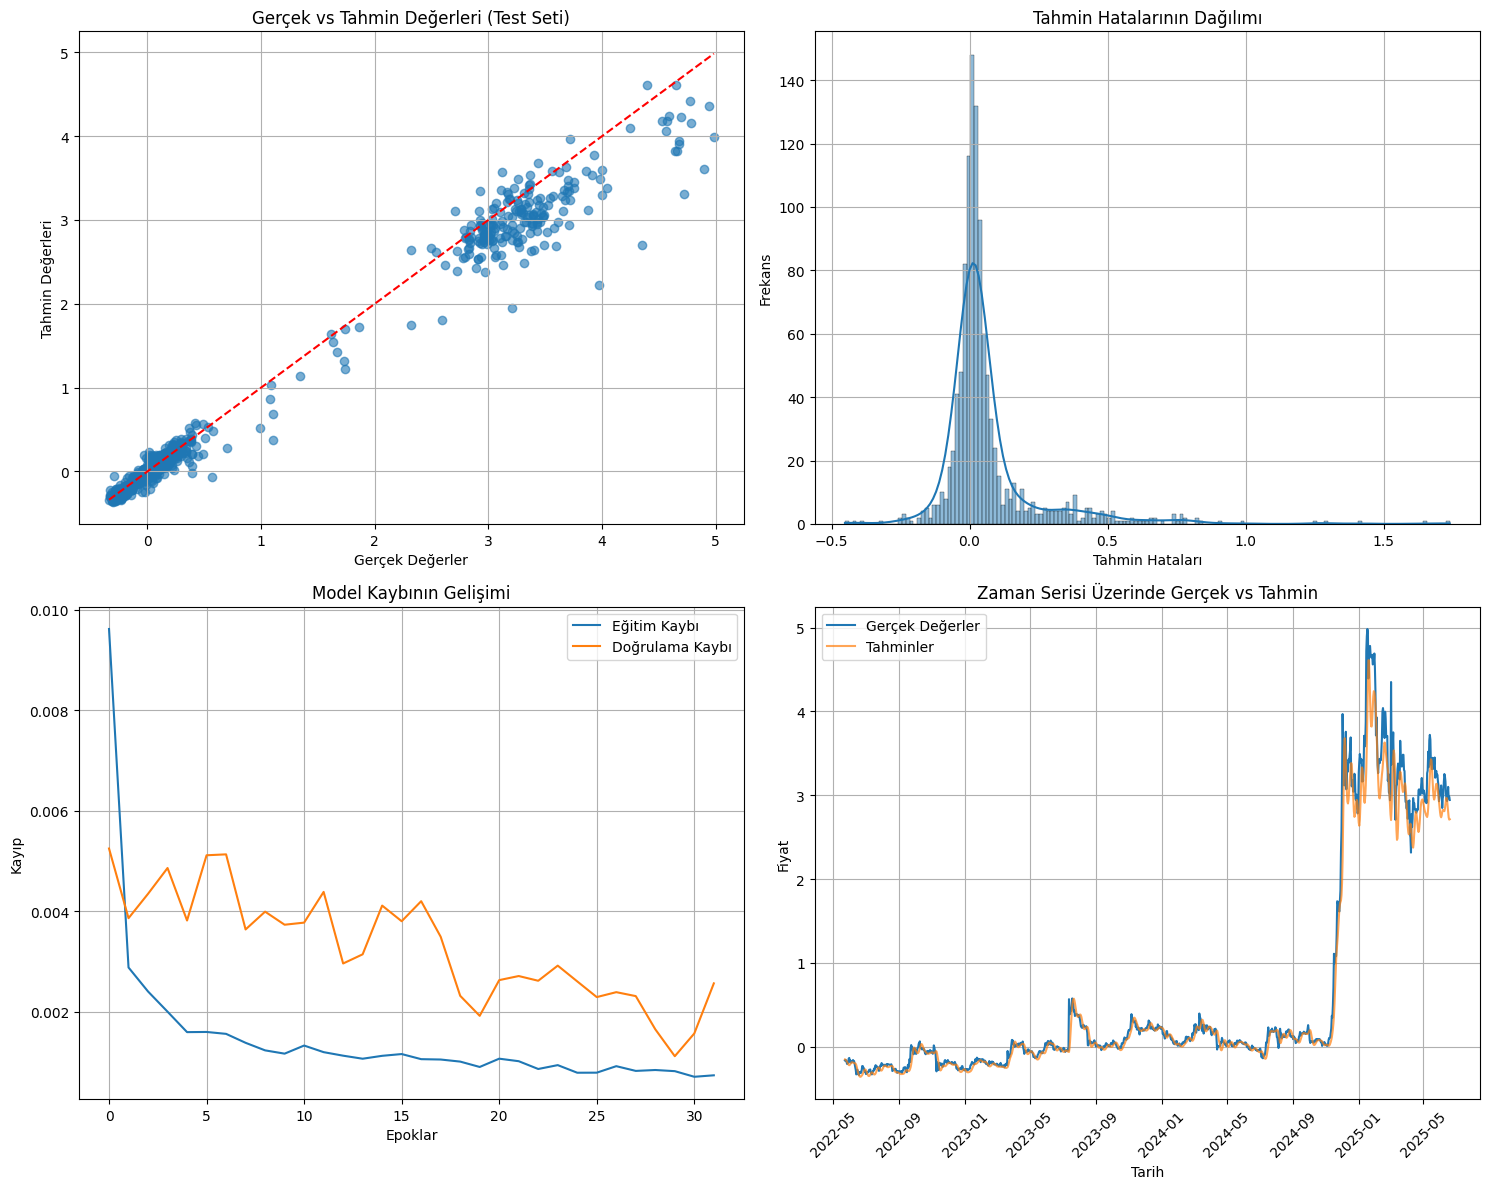

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

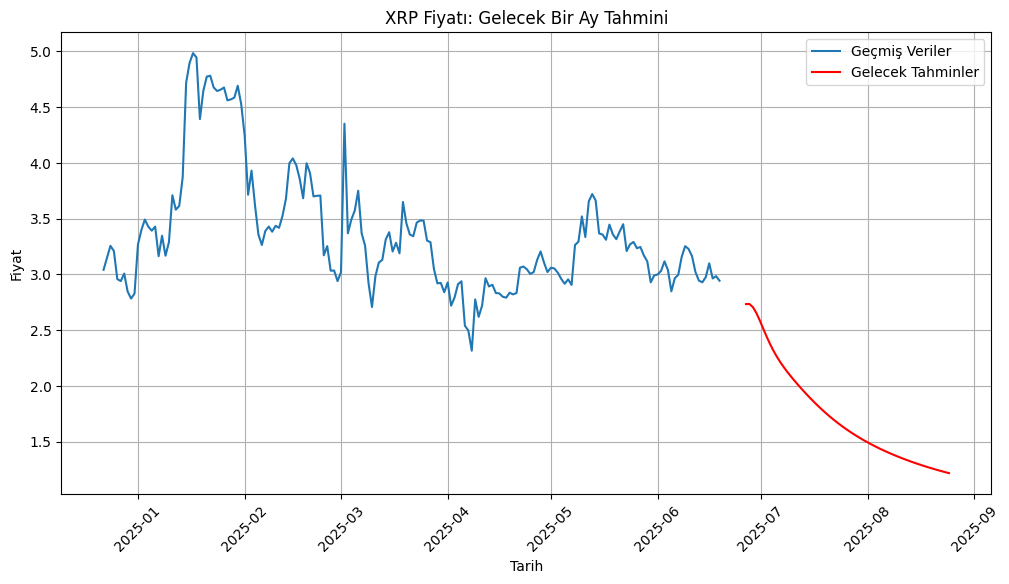

In [ ]:
# Grafikleri çizme
plt.figure(figsize=(15, 12))

# Gerçek vs Tahmin scatter plot
plt.subplot(2, 2, 1)
plt.scatter(y_test_actual, test_predict, alpha=0.6)
plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], 'r--')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmin Değerleri')
plt.title('Gerçek vs Tahmin Değerleri (Test Seti)')
plt.grid(True)

# Hata dağılımı histogramı
plt.subplot(2, 2, 2)
errors = y_test_actual.flatten() - test_predict.flatten()
sns.histplot(errors, kde=True)
plt.xlabel('Tahmin Hataları')
plt.ylabel('Frekans')
plt.title('Tahmin Hatalarının Dağılımı')
plt.grid(True)

# Kayıp eğrisi
plt.subplot(2, 2, 3)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoklar')
plt.ylabel('Kayıp')
plt.title('Model Kaybının Gelişimi')
plt.legend()
plt.grid(True)

# Gerçek vs Tahmin zaman serisi
plt.subplot(2, 2, 4)
test_dates = data.index[split_idx + SEQ_LENGTH:]
plt.plot(test_dates, y_test_actual, label='Gerçek Değerler')
plt.plot(test_dates, test_predict, label='Tahminler', alpha=0.7)
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.title('Zaman Serisi Üzerinde Gerçek vs Tahmin')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

today = datetime.today()

# Gelecek 30 günün tarihlerini oluştur
future_dates = [today + timedelta(days=i) for i in range(60)]

# Gelecek bir ayın tahminlerini yapma ve listede tutma
future_predictions = []
current_sequence = scaled_data[-SEQ_LENGTH:].reshape(1, SEQ_LENGTH, 1)  # scaled_data: ölçeklendirilmiş son veriler
for i in range(60):
    next_pred_scaled = model.predict(current_sequence)  # model: önceden eğitilmiş tahmin modeli
    next_pred = scaler.inverse_transform(next_pred_scaled)  # scaler: veriyi ölçeklendiren araç
    future_predictions.append((future_dates[i], next_pred[0, 0]))
    next_pred_scaled_reshaped = next_pred_scaled.reshape(1, 1, 1)
    current_sequence = np.append(current_sequence[:, 1:, :], next_pred_scaled_reshaped, axis=1)

# Tahminleri DataFrame'e çevirme
future_df = pd.DataFrame(future_predictions, columns=['Date', 'Price'])
# future_df['Date'] = future_df['Date'].dt.strftime('%Y-%m-%d') # Bu satırı kaldırın

# Tahminleri CSV dosyasına kaydetme
future_df.to_csv('future_predictions.csv', index=False)

# Grafik çizimi (örnek geçmiş veri ile)
last_180_days = data.iloc[-180:]  # data: geçmiş verileri içeren DataFrame
plt.figure(figsize=(12, 6))
plt.plot(last_180_days.index, last_180_days['Price'], label='Geçmiş Veriler')
# future_df['Date'] already contains datetime objects, which Matplotlib can plot
plt.plot(future_df['Date'], future_df['Price'], label='Gelecek Tahminler', color='red')
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.title('XRP Fiyatı: Gelecek Bir Ay Tahmini')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import joblib
import keras_tuner as kt  # Corrected import
from datetime import datetime, timedelta

# Veriyi yükleme ve önişleme
def load_data():
    df = pd.read_csv('XRP_normalized.csv', parse_dates=['Date'])
    print("Eksik değer sayısı:", df.isnull().sum().sum())
    df = df.dropna(subset=['Price'])
    df = df.sort_values('Date')
    prices = df[['Date', 'Price']].set_index('Date')
    return prices

data = load_data()

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Zaman serisi verilerini LSTM için hazırlama
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 60
TEST_SIZE = 0.3
X, y = create_sequences(scaled_data, SEQ_LENGTH)
split_idx = int(len(X) * (1 - TEST_SIZE))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Hiperparametre optimizasyonu için model fonksiyonu
def build_model(hp):
    model = Sequential()

    # LSTM katman sayısı
    num_layers = hp.Int('num_layers', 1, 3)

    # İlk LSTM katmanı
    model.add(LSTM(
        units=hp.Int('units_1', min_value=32, max_value=256, step=32),
        return_sequences=num_layers > 1,
        input_shape=(SEQ_LENGTH, 1)
    ))
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1)))

    # Ek LSTM katmanları
    for i in range(1, num_layers):
        return_sequences = (i < num_layers - 1)
        model.add(LSTM(
            units=hp.Int(f'units_{i+1}', min_value=32, max_value=256, step=32),
            return_sequences=return_sequences
        ))
        model.add(Dropout(hp.Float(f'dropout_{i+1}', 0.1, 0.5, step=0.1)))

    # Yoğun katmanlar
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))

    # Optimizer ve derleme
    optimizer = Adam(
        learning_rate=hp.Choice('learning_rate', [1e-4, 5e-4, 1e-3, 5e-3, 1e-2])
    )
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Hiperband tuner'ı başlatma
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=30,
    factor=3,
    directory='tuner_results',
    project_name='xrp_lstm_tuning'
)

# Erken durdurma
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Hiperparametre aramasını başlatma
tuner.search(
    X_train, y_train,
    epochs=50,
    batch_size=32, # Removed hp.Choice
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# En iyi hiperparametreleri al
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Optimal hiperparametreler:
- LSTM Katman Sayısı: {best_hps.get('num_layers')}
- Katman 1 Birim Sayısı: {best_hps.get('units_1')}
- Katman 1 Dropout: {best_hps.get('dropout_1')}
- Öğrenme Oranı: {best_hps.get('learning_rate')}
- Batch Size: {best_hps.get('batch_size')}
""")

# En iyi model ile eğitim
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=best_hps.get('batch_size'),
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# Tahmin ve değerlendirme (orijinal kodun geri kalanı aynı kalır)
# ... (Bu kısım orijinal kodunuzdaki gibi devam edecek)

Trial 90 Complete [00h 00m 18s]
val_loss: 0.001201134524308145

Best val_loss So Far: 0.0003421660221647471
Total elapsed time: 00h 14m 13s


KeyError: 'batch_size does not exist.'

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 11.1 MB/s eta 0:00:00


In [ ]:
# Grafikleri çizme
plt.figure(figsize=(15, 12))

# Gerçek vs Tahmin scatter plot
plt.subplot(2, 2, 1)
plt.scatter(y_test_actual, test_predict, alpha=0.6)
plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], 'r--')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmin Değerleri')
plt.title('Gerçek vs Tahmin Değerleri (Test Seti)')
plt.grid(True)

# Hata dağılımı histogramı
plt.subplot(2, 2, 2)
errors = y_test_actual.flatten() - test_predict.flatten()
sns.histplot(errors, kde=True)
plt.xlabel('Tahmin Hataları')
plt.ylabel('Frekans')
plt.title('Tahmin Hatalarının Dağılımı')
plt.grid(True)

# Kayıp eğrisi
plt.subplot(2, 2, 3)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoklar')
plt.ylabel('Kayıp')
plt.title('Model Kaybının Gelişimi')
plt.legend()
plt.grid(True)

# Gerçek vs Tahmin zaman serisi
plt.subplot(2, 2, 4)
test_dates = data.index[split_idx + SEQ_LENGTH:]
plt.plot(test_dates, y_test_actual, label='Gerçek Değerler')
plt.plot(test_dates, test_predict, label='Tahminler', alpha=0.7)
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.title('Zaman Serisi Üzerinde Gerçek vs Tahmin')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

today = datetime.today()

# Gelecek 30 günün tarihlerini oluştur
future_dates = [today + timedelta(days=i) for i in range(30)]

# Gelecek bir ayın tahminlerini yapma ve listede tutma
future_predictions = []
current_sequence = scaled_data[-SEQ_LENGTH:].reshape(1, SEQ_LENGTH, 1)  # scaled_data: ölçeklendirilmiş son veriler
for i in range(30):
    next_pred_scaled = model.predict(current_sequence)  # model: önceden eğitilmiş tahmin modeli
    next_pred = scaler.inverse_transform(next_pred_scaled)  # scaler: veriyi ölçeklendiren araç
    future_predictions.append((future_dates[i], next_pred[0, 0]))
    next_pred_scaled_reshaped = next_pred_scaled.reshape(1, 1, 1)
    current_sequence = np.append(current_sequence[:, 1:, :], next_pred_scaled_reshaped, axis=1)

# Tahminleri DataFrame'e çevirme
future_df = pd.DataFrame(future_predictions, columns=['Date', 'Price'])
# future_df['Date'] = future_df['Date'].dt.strftime('%Y-%m-%d') # Bu satırı kaldırın

# Tahminleri CSV dosyasına kaydetme
future_df.to_csv('future_predictions.csv', index=False)

# Grafik çizimi (örnek geçmiş veri ile)
last_180_days = data.iloc[-180:]  # data: geçmiş verileri içeren DataFrame
plt.figure(figsize=(12, 6))
plt.plot(last_180_days.index, last_180_days['Price'], label='Geçmiş Veriler')
# future_df['Date'] already contains datetime objects, which Matplotlib can plot
plt.plot(future_df['Date'], future_df['Price'], label='Gelecek Tahminler', color='red')
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.title('XRP Fiyatı: Gelecek Bir Ay Tahmini')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import joblib
import kerastuner as kt
from datetime import datetime, timedelta

# Veriyi yükleme ve önişleme
def load_data():
    df = pd.read_csv('XRP_normalized.csv', parse_dates=['Date'])
    print("Eksik değer sayısı:", df.isnull().sum().sum())
    df = df.dropna(subset=['Price'])
    df = df.sort_values('Date')
    prices = df[['Date', 'Price']].set_index('Date')
    return prices

data = load_data()

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Zaman serisi verilerini LSTM için hazırlama
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 60
TEST_SIZE = 0.3
X, y = create_sequences(scaled_data, SEQ_LENGTH)
split_idx = int(len(X) * (1 - TEST_SIZE))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Hiperparametre optimizasyonu için model fonksiyonu
def build_model(hp):
    model = Sequential()

    # LSTM katman sayısı
    num_layers = hp.Int('num_layers', 1, 3)

    # İlk LSTM katmanı
    model.add(LSTM(
        units=hp.Int('units_1', min_value=32, max_value=256, step=32),
        return_sequences=num_layers > 1,
        input_shape=(SEQ_LENGTH, 1)
    ))
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1)))

    # Ek LSTM katmanları
    for i in range(1, num_layers):
        return_sequences = (i < num_layers - 1)
        model.add(LSTM(
            units=hp.Int(f'units_{i+1}', min_value=32, max_value=256, step=32),
            return_sequences=return_sequences
        ))
        model.add(Dropout(hp.Float(f'dropout_{i+1}', 0.1, 0.5, step=0.1)))

    # Yoğun katmanlar
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))

    # Optimizer ve derleme
    optimizer = Adam(
        learning_rate=hp.Choice('learning_rate', [1e-4, 5e-4, 1e-3, 5e-3, 1e-2])
    )
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Hiperband tuner'ı başlatma
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=30,
    factor=3,
    directory='tuner_results',
    project_name='xrp_lstm_tuning',
    overwrite=True
)

# Erken durdurma
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Hiperparametre aramasını başlatma (DÜZELTME: hp burada kullanılmaz)
tuner.search(
    X_train, y_train,
    epochs=50,
    batch_size=32,  # Batch size sabit olarak ayarlandı
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# En iyi hiperparametreleri al
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Optimal hiperparametreler:
- LSTM Katman Sayısı: {best_hps.get('num_layers')}
- Katman 1 Birim Sayısı: {best_hps.get('units_1')}
- Katman 1 Dropout: {best_hps.get('dropout_1')}
- Öğrenme Oranı: {best_hps.get('learning_rate')}
""")

# En iyi model ile eğitim
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,  # Batch size sabit
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# ... (ORİJİNAL KODUN GERİ KALANI AYNI)

Trial 90 Complete [00h 00m 12s]
val_loss: 0.0005201025633141398

Best val_loss So Far: 0.0003271120658610016
Total elapsed time: 00h 13m 39s

Optimal hiperparametreler:
- LSTM Katman Sayısı: 1
- Katman 1 Birim Sayısı: 64
- Katman 1 Dropout: 0.2
- Öğrenme Oranı: 0.01

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0048 - val_loss: 0.0018
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.6596e-04 - val_loss: 0.0016
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.2868e-04 - val_loss: 6.7516e-04
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.2053e-04 - val_loss: 0.0014
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.0308e-04 - val_loss: 6.1271e-04
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.5168e-04 - val_loss: 5.5742e-04
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.6536e-04 - val_loss: 0.0010
Epoch 8/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.2773e-04 - val_loss: 9.8304e-04
Epoch 9/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.8275e-04 - val_loss: 5.3641e-04
Epoch 10/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.2603e-04 - val_loss: 7.0058e-04
Epoch 11/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.4910e-04 - val_loss: 3.9881e-04
Epo

In [ ]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.1 MB/s eta 0:00:00


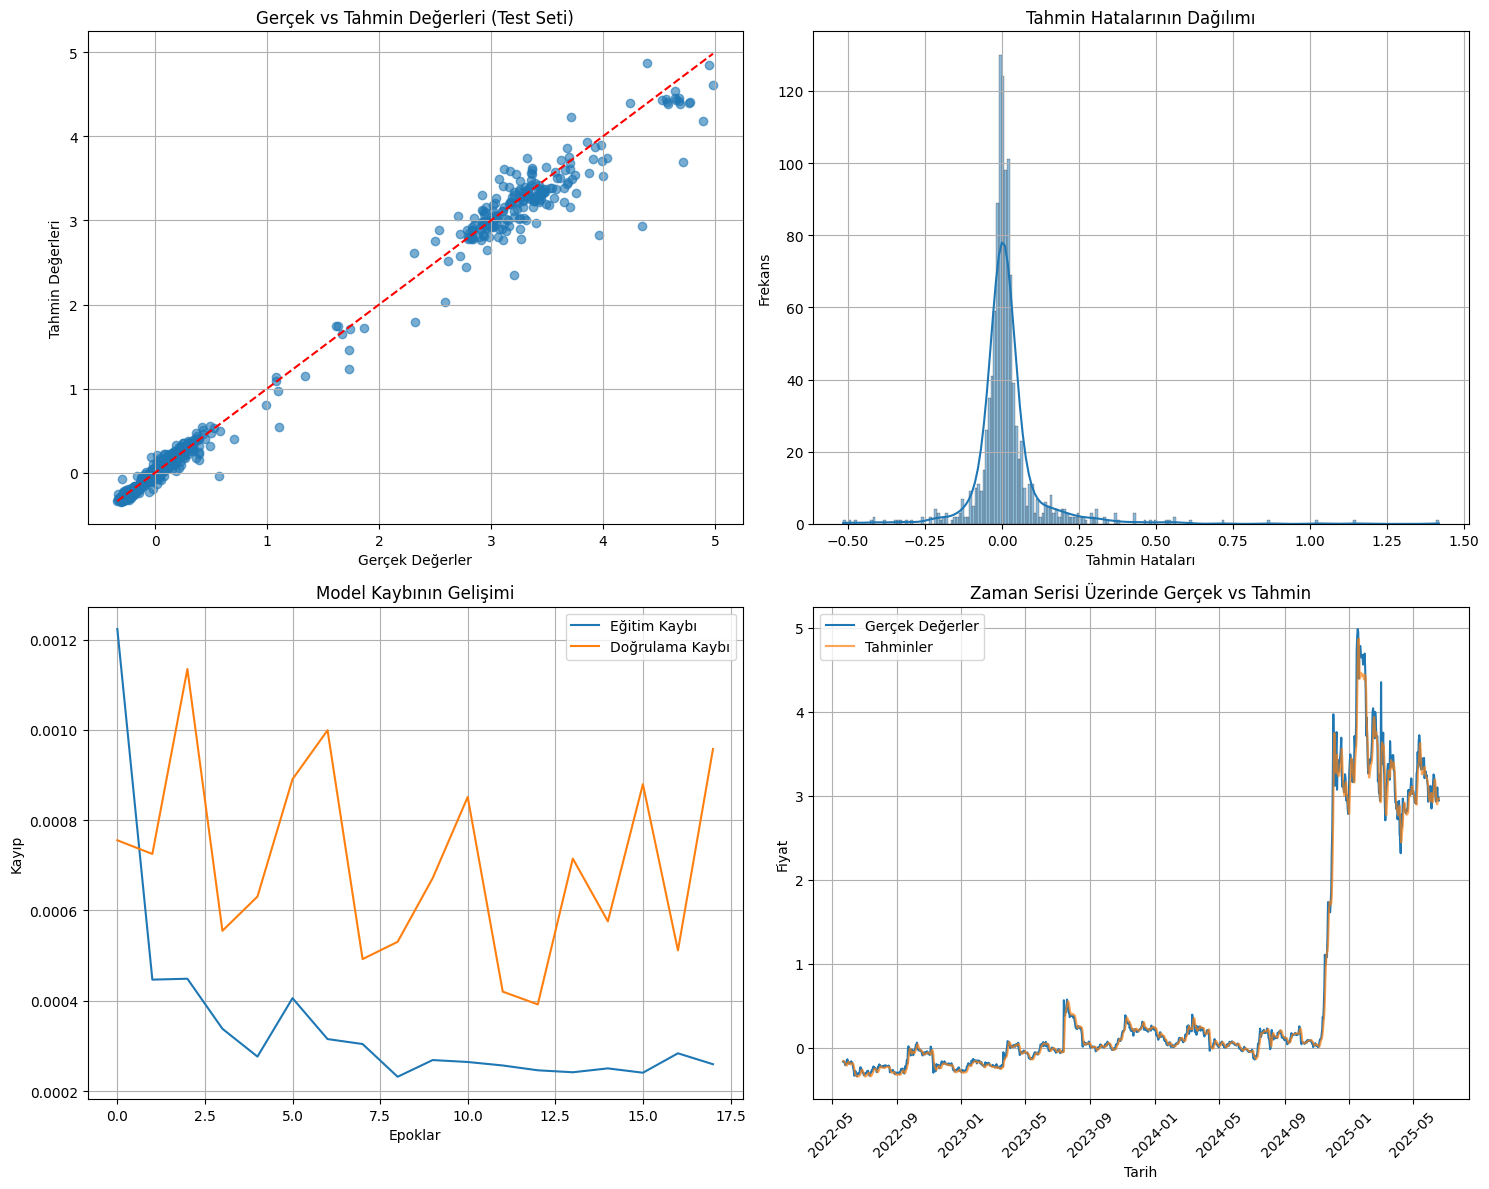

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

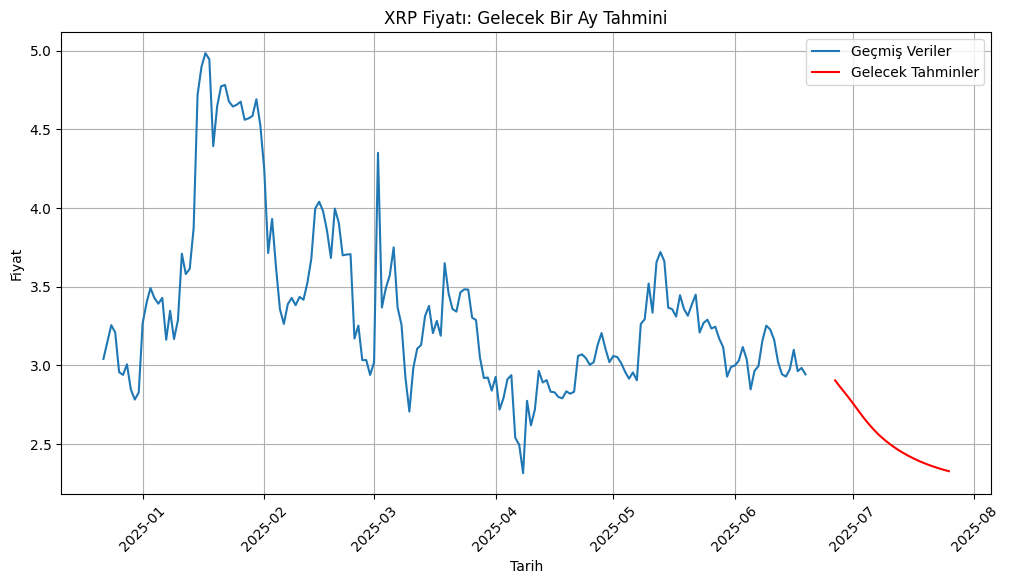

In [ ]:
# Grafikleri çizme
plt.figure(figsize=(15, 12))

# Gerçek vs Tahmin scatter plot
plt.subplot(2, 2, 1)
plt.scatter(y_test_actual, test_predict, alpha=0.6)
plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], 'r--')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmin Değerleri')
plt.title('Gerçek vs Tahmin Değerleri (Test Seti)')
plt.grid(True)

# Hata dağılımı histogramı
plt.subplot(2, 2, 2)
errors = y_test_actual.flatten() - test_predict.flatten()
sns.histplot(errors, kde=True)
plt.xlabel('Tahmin Hataları')
plt.ylabel('Frekans')
plt.title('Tahmin Hatalarının Dağılımı')
plt.grid(True)

# Kayıp eğrisi
plt.subplot(2, 2, 3)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoklar')
plt.ylabel('Kayıp')
plt.title('Model Kaybının Gelişimi')
plt.legend()
plt.grid(True)

# Gerçek vs Tahmin zaman serisi
plt.subplot(2, 2, 4)
test_dates = data.index[split_idx + SEQ_LENGTH:]
plt.plot(test_dates, y_test_actual, label='Gerçek Değerler')
plt.plot(test_dates, test_predict, label='Tahminler', alpha=0.7)
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.title('Zaman Serisi Üzerinde Gerçek vs Tahmin')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

today = datetime.today()

# Gelecek 30 günün tarihlerini oluştur
future_dates = [today + timedelta(days=i) for i in range(30)]

# Gelecek bir ayın tahminlerini yapma ve listede tutma
future_predictions = []
current_sequence = scaled_data[-SEQ_LENGTH:].reshape(1, SEQ_LENGTH, 1)  # scaled_data: ölçeklendirilmiş son veriler
for i in range(30):
    next_pred_scaled = model.predict(current_sequence)  # model: önceden eğitilmiş tahmin modeli
    next_pred = scaler.inverse_transform(next_pred_scaled)  # scaler: veriyi ölçeklendiren araç
    future_predictions.append((future_dates[i], next_pred[0, 0]))
    next_pred_scaled_reshaped = next_pred_scaled.reshape(1, 1, 1)
    current_sequence = np.append(current_sequence[:, 1:, :], next_pred_scaled_reshaped, axis=1)

# Tahminleri DataFrame'e çevirme
future_df = pd.DataFrame(future_predictions, columns=['Date', 'Price'])
# future_df['Date'] = future_df['Date'].dt.strftime('%Y-%m-%d') # Bu satırı kaldırın

# Tahminleri CSV dosyasına kaydetme
future_df.to_csv('future_predictions.csv', index=False)

# Grafik çizimi (örnek geçmiş veri ile)
last_180_days = data.iloc[-180:]  # data: geçmiş verileri içeren DataFrame
plt.figure(figsize=(12, 6))
plt.plot(last_180_days.index, last_180_days['Price'], label='Geçmiş Veriler')
# future_df['Date'] already contains datetime objects, which Matplotlib can plot
plt.plot(future_df['Date'], future_df['Price'], label='Gelecek Tahminler', color='red')
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.title('XRP Fiyatı: Gelecek Bir Ay Tahmini')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()
